In [1]:
import time
start_time = time.time()

In [2]:
from fastai.vision.all import *

/home/dev/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


# Prepare our training data

In [3]:
input_path = Path("/home/dev/AIprojects/digit-recognizer/")
train = pd.read_csv(input_path/"train.csv")

In [4]:
from torchvision import transforms

class NumberDataset:
    def __init__(self, data, transform=None):
        self.data = data.reset_index(drop=True)
        self.trans = transform
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        
        d = self.data.iloc[index, 1:].values.reshape(1, 28, 28)
        
        if self.trans:
            d = self.trans(tensor(d))
        else:
            d = tensor(d)/255
        
        y = self.data.iloc[index, 0]
        
        return d, tensor(y)

In [5]:
train_idx, valid_idx = RandomSplitter()(train)

device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = NumberDataset(train.iloc[train_idx, :])
valid_ds = NumberDataset(train.iloc[valid_idx, :])

train_dl = DataLoader(train_ds, bs=64)
valid_dl = DataLoader(valid_ds, bs=128)

dls = DataLoaders(train_dl, valid_dl).to(device)

# Build and Train the model

In [6]:
model = nn.Sequential(
    ConvLayer(1, 32),
    ConvLayer(32, 64),
    nn.MaxPool2d(2),
    ConvLayer(64, 128),
    ConvLayer(128, 256),
    nn.MaxPool2d(2),
    ConvLayer(256, 512),
    ConvLayer(512, 1024),
    nn.MaxPool2d(2),
    nn.AdaptiveAvgPool2d(1),
    Flatten(), 
    nn.Linear(1024, 256),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
).to(device)

In [7]:
learn = Learner(dls, model, metrics=accuracy, 
                loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(valley=0.00013182566908653826)

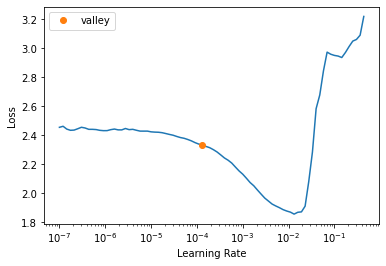

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(15, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.621695,0.672226,0.964881,01:19
1,0.584062,0.588387,0.989048,01:18
2,0.558116,0.569981,0.984286,01:18
3,0.540835,0.534651,0.993214,01:18
4,0.528046,0.528121,0.993810,01:18
5,0.520325,0.524018,0.993452,01:18
6,0.515303,0.523413,0.994405,01:18
7,0.511856,0.519161,0.994524,01:18
8,0.510393,0.518457,0.995000,01:18
9,0.508940,0.516207,0.995476,01:18


In [10]:
preds, targs = learn.get_preds()

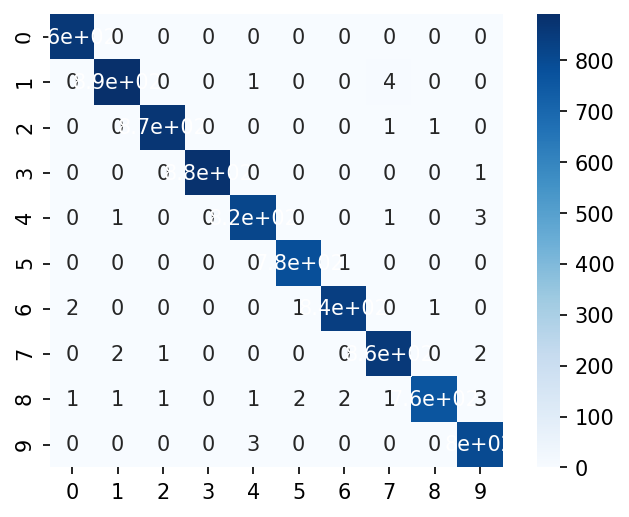

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


fig = plt.figure(dpi=150)
sns.heatmap(confusion_matrix(targs, preds.argmax(1)), cmap="Blues",
            square=True, annot=True);

# Make prediction on the test set

In [12]:
test = pd.read_csv(input_path/"test.csv")

In [13]:
class TestDS(NumberDataset):
    def __getitem__(self, index):
        
        d = self.data.iloc[index, :].values.reshape(1, 28, 28)
        
        if self.trans:
            d = self.trans(tensor(d)/255)
        else:
            d = tensor(d)/255
        
        return d, tensor(0)



test_ds = TestDS(test)
test_dl = DataLoader(test_ds, bs=128, device=device)

In [14]:
preds, targ = learn.get_preds(dl=test_dl)

In [15]:
sub = pd.read_csv(input_path/"sample_submission.csv")
sub["Label"] = np.argmax(preds, axis=1)
sub.to_csv("submission.csv", index=False)

In [16]:
print("Working time: %s seconds" % (time.time() - start_time))

Working time: 1229.22807264328 seconds
